# 카카오톡 대화 데이터 정제

In [1]:
import pandas as pd
import re
import MeCab

mecab = MeCab.Tagger()

In [2]:
# load data 
df = pd.read_csv("data/kaTalk.csv")
print(df.head())
print(df.info())

                  date user                                            message
0  2016. 3. 7. 오후 3:41   YH  안녕하세요! 이게 빠르지 않을까 해서요~ 엠티 관련해서는 회장님께서 이미 밴드에 올...
1  2016. 3. 7. 오후 3:51   WH                                        네 안녕하세요~ ^^
2  2016. 3. 7. 오후 5:14   YH  넵ㅋㅋ 저희 카톡방을 만들어서 거기다 투표를 돌릴까요 아님 그냥 밴드에 두개로 할까...
3  2016. 3. 7. 오후 5:21   KS                           엠티관련해서 참석여부 투표를 말씀하신건가요?
4  2016. 3. 7. 오후 5:22   YH                      네 저희 이번 토욜 관련해서도 투표를 올려야 해서요~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17161 entries, 0 to 17160
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     17161 non-null  object
 1   user     17161 non-null  object
 2   message  17161 non-null  object
dtypes: object(3)
memory usage: 402.3+ KB
None


In [3]:
corpus = df['message']
corpus

0        안녕하세요! 이게 빠르지 않을까 해서요~ 엠티 관련해서는 회장님께서 이미 밴드에 올...
1                                              네 안녕하세요~ ^^
2        넵ㅋㅋ 저희 카톡방을 만들어서 거기다 투표를 돌릴까요 아님 그냥 밴드에 두개로 할까...
3                                 엠티관련해서 참석여부 투표를 말씀하신건가요?
4                            네 저희 이번 토욜 관련해서도 투표를 올려야 해서요~
                               ...                        
17156                                       나머지는 알아서 형하라고해
17157                                      밑에 애가 맞먹는건 괜찮는데
17158                                                저기요..
17159                                                  어이~
17160                                          저기욬ㅋㅋㅋㅋㅋㅋㅋㅋ
Name: message, Length: 17161, dtype: object

### 데이터 전처리를 위해 전체 데이터의 특징을 빈도분석으로 파악

In [4]:
import nltk

total_tokens = [token for msg in corpus for token in str(msg).split()]
print(len(total_tokens))

43363


In [5]:
text = nltk.Text(total_tokens, name='katalk')

print(len(set(text.tokens)))
print(text.vocab().most_common(10))

22882
[('이모티콘', 1277), ('ㅋㅋㅋ', 605), ('ㅋㅋ', 578), ('ㅋㅋㅋㅋ', 339), ('ㅋㅋㅋㅋㅋ', 256), ('아', 223), ('사진', 206), ('ㅋㅋㅋㅋㅋㅋ', 203), ('나', 199), ('우리', 197)]


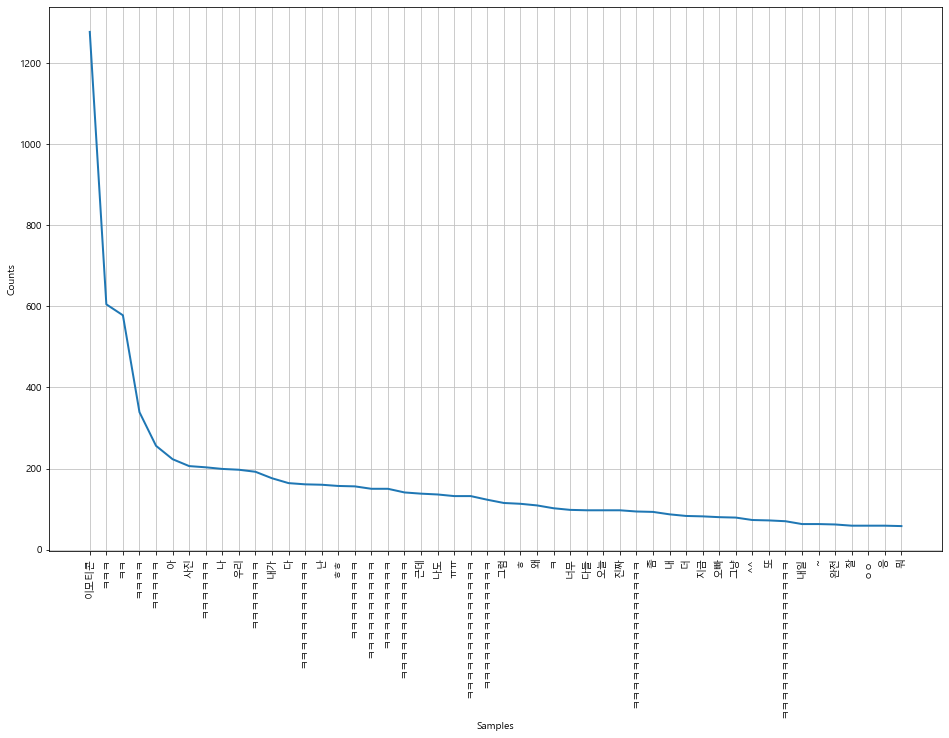

In [6]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

### 텍스트 정제

In [7]:
def message_cleaning(docs):

    """
        1. '사진', '이모티콘'은 그 내용을 알 수 없으므로 제거.
        
        2. 자음/모음으로만 된 표현 처리방법 선택.
        
            1) "ㅇㅇ", "ㅋㅋㅋㅋㅋ" 같은 자음만 존재하는 표현이나, "ㅡㅡ", "ㅠㅠ" 같은 모음만 존재하는 표현들은
            의미는 있으나 중요한 의미를 가지고 있지 않다고 판단하여 제거.
            2) 이러한 표현들도 전부 emoticon 같은 감정 표현의 의성어로 쓰거나, 단축 표현이므로 제거하지 않음. 
            
        3. http:// 로 시작하는 hyperlink 제거.
        
        4. 특수문자 제거.
    
    """
    
    # Series의 object를 str로 변경.
    docs = [str(doc) for doc in docs]
    
    # 1
    pattern1 = re.compile("사진|이모티콘")
    docs = [pattern1.sub("", doc) for doc in docs]
    
    # 2
    pattern2 = re.compile("[ㄱ-ㅎ]*[ㅏ-ㅢ]*")
    docs = [pattern2.sub("", doc) for doc in docs]
    
    # 3
    pattern3 = re.compile(r"\b(https?:\/\/)?([\w.]+){1,2}(\.[\w]{2,4}){1,2}(.*)")
    docs = [pattern3.sub("", doc) for doc in docs]
    
    # 4
    pattern4 = re.compile("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]")
    docs = [pattern4.sub("", doc) for doc in docs]

    return docs

def define_stopwords(path):
    
    SW = set()

    # SW.add("있다")
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
            
    return SW

def mecab_morphs(text):
    morphs = []

    pattern = re.compile(".*\t[A-Z]+")
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
    for token in temp:
        morphs.append(token[0])

    return morphs

def text_tokenizing(doc):
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]

In [8]:
SW = define_stopwords("stopwords-ko.txt")

cleaned_corpus = message_cleaning(corpus)

print(len(cleaned_corpus))
print(cleaned_corpus[:10])

17161
['안녕하세요 이게 빠르지 않을까 해서요 엠티 관련해서는 회장님께서 이미 밴드에 올려 주셨어요', '네 안녕하세요 ', '넵 저희 카톡방을 만들어서 거기다 투표를 돌릴까요 아님 그냥 밴드에 두개로 할까요 총무님', '엠티관련해서 참석여부 투표를 말씀하신건가요', '네 저희 이번 토욜 관련해서도 투표를 올려야 해서요', '밴드보다는 카톡이 더 접근성이 있지 않을까요', '제가 연락처 다 저장해서 전체 카톡방 만들겠습니다', '혹시 정도상님 연락처가 카톡에 저장되지 않는데', '혹시 저장되신분 있으신가요', '연락처 정도상5기 KMBDMBA']


In [9]:
# 정제후에 텍스트가 없는 row 삭제

cleaned_text = pd.Series(cleaned_corpus)
df["message"] = cleaned_text

cleaned_data = df[df["message"] != ""]
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14911 entries, 0 to 17160
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     14911 non-null  object
 1   user     14911 non-null  object
 2   message  14911 non-null  object
dtypes: object(3)
memory usage: 466.0+ KB


In [10]:
cleaned_data.head()

,date,user,message
0,2016. 3. 7. 오후 3:41,YH,안녕하세요 이게 빠르지 않을까 해서요 엠티 관련해서는 회장님께서 이미 밴드에 올려 ...
1,2016. 3. 7. 오후 3:51,WH,네 안녕하세요
2,2016. 3. 7. 오후 5:14,YH,넵 저희 카톡방을 만들어서 거기다 투표를 돌릴까요 아님 그냥 밴드에 두개로 할까요 총무님
3,2016. 3. 7. 오후 5:21,KS,엠티관련해서 참석여부 투표를 말씀하신건가요
4,2016. 3. 7. 오후 5:22,YH,네 저희 이번 토욜 관련해서도 투표를 올려야 해서요


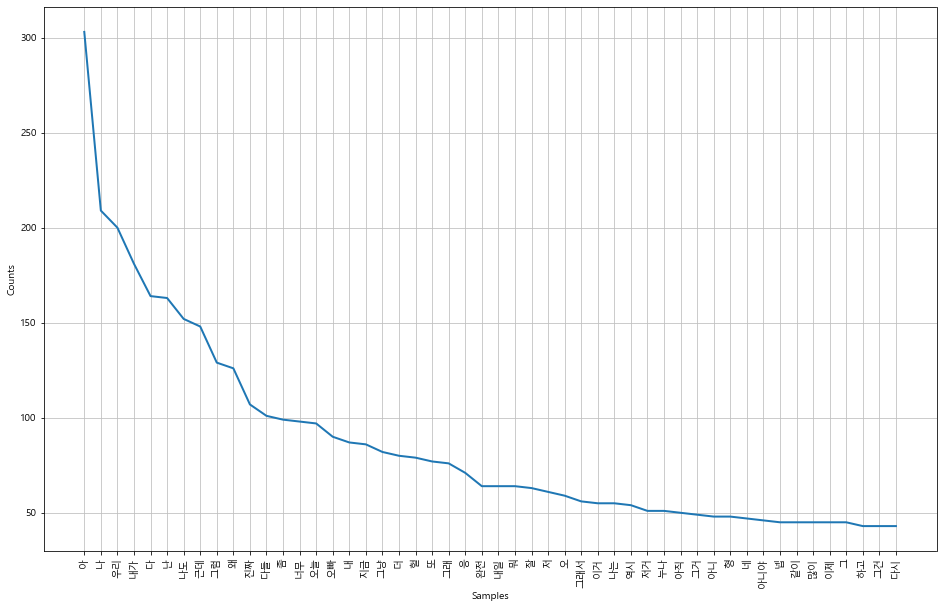

In [11]:
# 정제한 데이터 확인

corpus = df['message']
total_tokens = [token for msg in corpus for token in str(msg).split()]
text = nltk.Text(total_tokens, name='katalk')

plt.figure(figsize=(16, 10))
text.plot(50)

In [12]:
# 정제한 데이터 저장.

import pickle

with open("data/cleaned_katalk_data.pk", "wb") as f:
    pickle.dump(cleaned_data, f)